# Baseline Results for Binary Classification (pain vs. no pain)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant
from keras.layers.advanced_activations import PReLU

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, load_fusioned_dataset

In [2]:
epochs, batch_size = 25, 32
kf = KFold(n_splits=3, shuffle=True, random_state=48)
auc_list = []

In [8]:
class BaselineLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        lstm = LSTM(128)(input)
        dense = Dense(256, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

## 1. Unimodal Body Modality (Skeleton)

### Dataset

In [4]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(783, 1, 350, 35) (783, 1)
(274, 1, 350, 35) (274, 1)


### Baseline Model

In [9]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    binary_body_model = BaselineLSTM(n_features, n_length, n_outputs)
    history = binary_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

TypeError: __init__() missing 2 required positional arguments: 'n_length' and 'n_outputs'

#### Predictions on the holdout set

In [40]:
y_pred = binary_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = binary_body_model.evaluate(X_test, y_test)
auc_list.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 63.87% 
ROC/AUC: 0.59 
Precision: 0.86 
Recall: 0.69 
F1 score: 0.92


## 2. Unimodal Face Modality (Action Units + Head Pose)

### Dataset

In [43]:
X_train, X_test, y_train, y_test = load_dataset('AUs', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(752, 1, 350, 25) (752, 1)
(268, 1, 350, 25) (268, 1)


### CNN + Bidirectional LSTM

Epoch 1/25
16/16 - 4s - loss: 19203.3516 - accuracy: 0.5050 - auc_30: 0.5046 - precision_30: 0.4888 - recall_30: 0.5413 - f1_score: 0.5739 - val_loss: 1002.8542 - val_accuracy: 0.5219 - val_auc_30: 0.5129 - val_precision_30: 0.7500 - val_recall_30: 0.0484 - val_f1_score: 0.6241 - 4s/epoch - 221ms/step
Epoch 2/25
16/16 - 1s - loss: 2464.9902 - accuracy: 0.5529 - auc_30: 0.5430 - precision_30: 0.5643 - recall_30: 0.3264 - f1_score: 0.5422 - val_loss: 46702.7070 - val_accuracy: 0.5100 - val_auc_30: 0.5040 - val_precision_30: 1.0000 - val_recall_30: 0.0081 - val_f1_score: 0.0160 - 703ms/epoch - 44ms/step
Epoch 3/25
16/16 - 1s - loss: 29430.7090 - accuracy: 0.5110 - auc_30: 0.5088 - precision_30: 0.4931 - recall_30: 0.4421 - f1_score: 0.4736 - val_loss: 536.6018 - val_accuracy: 0.5020 - val_auc_30: 0.5078 - val_precision_30: 0.4980 - val_recall_30: 0.9919 - val_f1_score: 0.6631 - 720ms/epoch - 45ms/step
Epoch 4/25
16/16 - 1s - loss: 15039.1738 - accuracy: 0.4890 - auc_30: 0.5058 - precision

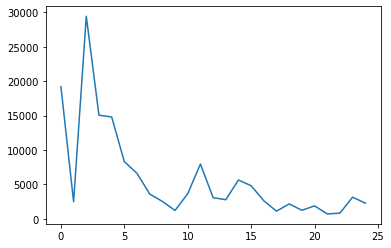

Epoch 1/25
16/16 - 3s - loss: 15562.9297 - accuracy: 0.4970 - auc_31: 0.5058 - precision_31: 0.4896 - recall_31: 0.8683 - f1_score: 0.6314 - val_loss: 10701.0547 - val_accuracy: 0.4900 - val_auc_31: 0.5035 - val_precision_31: 0.4899 - val_recall_31: 0.9837 - val_f1_score: 0.6541 - 3s/epoch - 197ms/step
Epoch 2/25
16/16 - 1s - loss: 8002.6313 - accuracy: 0.4890 - auc_31: 0.5038 - precision_31: 0.4869 - recall_31: 0.9959 - f1_score: 0.6541 - val_loss: 9232.4443 - val_accuracy: 0.4980 - val_auc_31: 0.5078 - val_precision_31: 0.4940 - val_recall_31: 1.0000 - val_f1_score: 0.6613 - 773ms/epoch - 48ms/step
Epoch 3/25
16/16 - 1s - loss: 7527.1826 - accuracy: 0.4571 - auc_31: 0.4599 - precision_31: 0.4652 - recall_31: 0.7984 - f1_score: 0.6241 - val_loss: 7229.9917 - val_accuracy: 0.4980 - val_auc_31: 0.4878 - val_precision_31: 0.4876 - val_recall_31: 0.4797 - val_f1_score: 0.6558 - 735ms/epoch - 46ms/step
Epoch 4/25
16/16 - 1s - loss: 4219.3755 - accuracy: 0.4990 - auc_31: 0.4921 - precision_

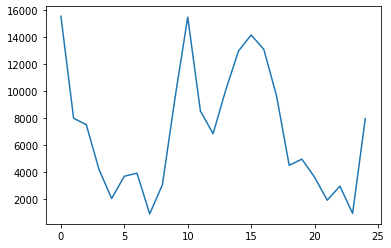

Epoch 1/25
16/16 - 3s - loss: 13698.3779 - accuracy: 0.4841 - auc_32: 0.4889 - precision_32: 0.4781 - recall_32: 0.5304 - f1_score: 0.5484 - val_loss: 5032.3198 - val_accuracy: 0.5640 - val_auc_32: 0.5951 - val_precision_32: 0.5231 - val_recall_32: 0.9496 - val_f1_score: 0.6503 - 3s/epoch - 196ms/step
Epoch 2/25
16/16 - 1s - loss: 1447.2825 - accuracy: 0.5100 - auc_32: 0.5095 - precision_32: 0.5013 - recall_32: 0.7611 - f1_score: 0.6413 - val_loss: 15943.5674 - val_accuracy: 0.4640 - val_auc_32: 0.4870 - val_precision_32: 0.4694 - val_recall_32: 0.9664 - val_f1_score: 0.6319 - 719ms/epoch - 45ms/step
Epoch 3/25
16/16 - 1s - loss: 3057.7341 - accuracy: 0.4980 - auc_32: 0.4991 - precision_32: 0.4946 - recall_32: 0.9352 - f1_score: 0.6548 - val_loss: 28237.2559 - val_accuracy: 0.4640 - val_auc_32: 0.4870 - val_precision_32: 0.4694 - val_recall_32: 0.9664 - val_f1_score: 0.6319 - 715ms/epoch - 45ms/step
Epoch 4/25
16/16 - 1s - loss: 615.5029 - accuracy: 0.5000 - auc_32: 0.5078 - precision_

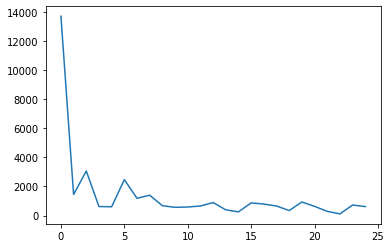

In [44]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_face_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [45]:
y_pred = cnnlstm_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_face_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 64.55% 
ROC/AUC: 0.62 
Precision: 0.90 
Recall: 0.66 
F1 score: 0.91


### RCNN

Epoch 1/25
16/16 - 2s - loss: 1.0063 - accuracy: 0.4850 - auc_33: 0.4998 - precision_33: 0.4728 - recall_33: 0.5744 - f1_score: 0.6514 - val_loss: 0.9760 - val_accuracy: 0.4980 - val_auc_33: 0.5199 - val_precision_33: 0.4960 - val_recall_33: 0.9919 - val_f1_score: 0.6613 - 2s/epoch - 106ms/step
Epoch 2/25
16/16 - 0s - loss: 0.9654 - accuracy: 0.5050 - auc_33: 0.4731 - precision_33: 0.4821 - recall_33: 0.3347 - f1_score: 0.6514 - val_loss: 0.8902 - val_accuracy: 0.4980 - val_auc_33: 0.5158 - val_precision_33: 0.4960 - val_recall_33: 0.9919 - val_f1_score: 0.6613 - 371ms/epoch - 23ms/step
Epoch 3/25
16/16 - 0s - loss: 0.8108 - accuracy: 0.5070 - auc_33: 0.5437 - precision_33: 0.4946 - recall_33: 0.9504 - f1_score: 0.6514 - val_loss: 0.8139 - val_accuracy: 0.5179 - val_auc_33: 0.5158 - val_precision_33: 0.8000 - val_recall_33: 0.0323 - val_f1_score: 0.6613 - 374ms/epoch - 23ms/step
Epoch 4/25
16/16 - 0s - loss: 0.7354 - accuracy: 0.5669 - auc_33: 0.6101 - precision_33: 0.6812 - recall_33:

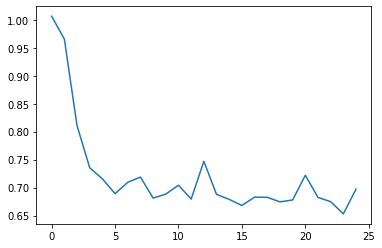

Epoch 1/25
16/16 - 2s - loss: 1.0285 - accuracy: 0.4870 - auc_34: 0.4790 - precision_34: 0.4765 - recall_34: 0.5844 - f1_score: 0.6532 - val_loss: 0.8499 - val_accuracy: 0.5100 - val_auc_34: 0.5746 - val_precision_34: 0.0000e+00 - val_recall_34: 0.0000e+00 - val_f1_score: 0.6578 - 2s/epoch - 106ms/step
Epoch 2/25
16/16 - 0s - loss: 0.7881 - accuracy: 0.5329 - auc_34: 0.5358 - precision_34: 0.5338 - recall_34: 0.2922 - f1_score: 0.6532 - val_loss: 0.7928 - val_accuracy: 0.4940 - val_auc_34: 0.5166 - val_precision_34: 0.4920 - val_recall_34: 1.0000 - val_f1_score: 0.6578 - 414ms/epoch - 26ms/step
Epoch 3/25
16/16 - 0s - loss: 0.7618 - accuracy: 0.5429 - auc_34: 0.5447 - precision_34: 0.6129 - recall_34: 0.1564 - f1_score: 0.6532 - val_loss: 0.7341 - val_accuracy: 0.5179 - val_auc_34: 0.5706 - val_precision_34: 0.6667 - val_recall_34: 0.0325 - val_f1_score: 0.6578 - 391ms/epoch - 24ms/step
Epoch 4/25
16/16 - 0s - loss: 0.6961 - accuracy: 0.5669 - auc_34: 0.6156 - precision_34: 0.5565 - re

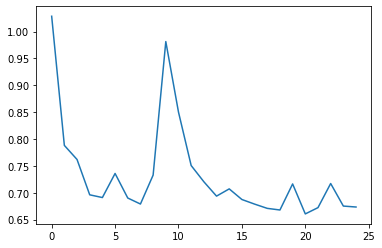

Epoch 1/25
16/16 - 2s - loss: 0.9569 - accuracy: 0.5657 - auc_35: 0.5814 - precision_35: 0.5801 - recall_35: 0.4251 - f1_score: 0.6595 - val_loss: 1.9408 - val_accuracy: 0.5360 - val_auc_35: 0.5562 - val_precision_35: 0.6667 - val_recall_35: 0.0504 - val_f1_score: 0.6319 - 2s/epoch - 105ms/step
Epoch 2/25
16/16 - 0s - loss: 0.9820 - accuracy: 0.5120 - auc_35: 0.5090 - precision_35: 0.5026 - recall_35: 0.7773 - f1_score: 0.6613 - val_loss: 1.4954 - val_accuracy: 0.4680 - val_auc_35: 0.5107 - val_precision_35: 0.4713 - val_recall_35: 0.9664 - val_f1_score: 0.6319 - 393ms/epoch - 25ms/step
Epoch 3/25
16/16 - 0s - loss: 0.7614 - accuracy: 0.5199 - auc_35: 0.5713 - precision_35: 0.5072 - recall_35: 0.8502 - f1_score: 0.6595 - val_loss: 0.9577 - val_accuracy: 0.4680 - val_auc_35: 0.6269 - val_precision_35: 0.4713 - val_recall_35: 0.9664 - val_f1_score: 0.6450 - 408ms/epoch - 25ms/step
Epoch 4/25
16/16 - 0s - loss: 0.7362 - accuracy: 0.5359 - auc_35: 0.5716 - precision_35: 0.5583 - recall_35:

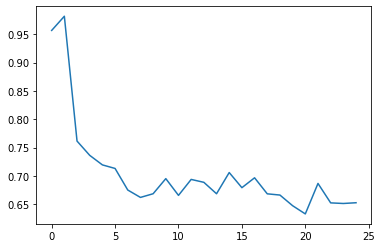

In [46]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_face_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Evaluation on the holdout set

In [47]:
y_pred = rcnn_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_face_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 14.55% 
ROC/AUC: 0.49 
Precision: 0.67 
Recall: 0.02 
F1 score: 0.93


## 3. Multimodal Early Fusion

### Dataset

In [48]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(752, 1, 350, 60) (752, 1)
(268, 1, 350, 60) (268, 1)


### CNN + Bidirectional LSTM

Epoch 1/25
16/16 - 3s - loss: 10781.3242 - accuracy: 0.5090 - auc_36: 0.5030 - precision_36: 0.4927 - recall_36: 0.5579 - f1_score: 0.6051 - val_loss: 5801.1143 - val_accuracy: 0.5299 - val_auc_36: 0.5294 - val_precision_36: 0.5195 - val_recall_36: 0.6452 - val_f1_score: 0.6482 - 3s/epoch - 200ms/step
Epoch 2/25
16/16 - 1s - loss: 5187.1245 - accuracy: 0.5589 - auc_36: 0.5668 - precision_36: 0.5533 - recall_36: 0.4504 - f1_score: 0.5959 - val_loss: 24785.9121 - val_accuracy: 0.5100 - val_auc_36: 0.5040 - val_precision_36: 1.0000 - val_recall_36: 0.0081 - val_f1_score: 0.0159 - 783ms/epoch - 49ms/step
Epoch 3/25
16/16 - 1s - loss: 7709.1836 - accuracy: 0.4890 - auc_36: 0.4846 - precision_36: 0.4679 - recall_36: 0.4215 - f1_score: 0.5181 - val_loss: 2624.6899 - val_accuracy: 0.4900 - val_auc_36: 0.4856 - val_precision_36: 0.3750 - val_recall_36: 0.0484 - val_f1_score: 0.4128 - 770ms/epoch - 48ms/step
Epoch 4/25
16/16 - 1s - loss: 8865.7168 - accuracy: 0.4711 - auc_36: 0.4624 - precision_

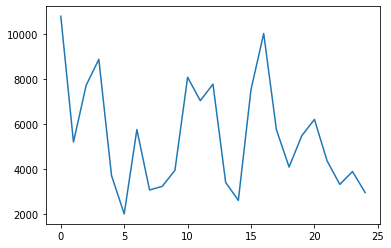

Epoch 1/25
16/16 - 3s - loss: 19490.6738 - accuracy: 0.5030 - auc_37: 0.5002 - precision_37: 0.4907 - recall_37: 0.6502 - f1_score: 0.6080 - val_loss: 2450.1777 - val_accuracy: 0.4940 - val_auc_37: 0.5039 - val_precision_37: 0.4920 - val_recall_37: 1.0000 - val_f1_score: 0.6595 - 3s/epoch - 203ms/step
Epoch 2/25
16/16 - 1s - loss: 8315.0996 - accuracy: 0.4930 - auc_37: 0.4949 - precision_37: 0.4848 - recall_37: 0.7243 - f1_score: 0.6179 - val_loss: 5524.7739 - val_accuracy: 0.5219 - val_auc_37: 0.5214 - val_precision_37: 0.8000 - val_recall_37: 0.0325 - val_f1_score: 0.5752 - 809ms/epoch - 51ms/step
Epoch 3/25
16/16 - 1s - loss: 7095.6426 - accuracy: 0.4711 - auc_37: 0.4798 - precision_37: 0.4689 - recall_37: 0.6831 - f1_score: 0.5910 - val_loss: 4794.6807 - val_accuracy: 0.4940 - val_auc_37: 0.5039 - val_precision_37: 0.4920 - val_recall_37: 1.0000 - val_f1_score: 0.6595 - 781ms/epoch - 49ms/step
Epoch 4/25
16/16 - 1s - loss: 6459.9878 - accuracy: 0.4531 - auc_37: 0.4362 - precision_3

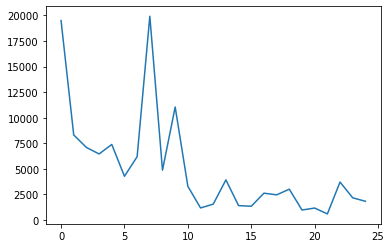

Epoch 1/25
16/16 - 4s - loss: 4234.6421 - accuracy: 0.4622 - auc_38: 0.4576 - precision_38: 0.4644 - recall_38: 0.6073 - f1_score: 0.5550 - val_loss: 28429.1562 - val_accuracy: 0.4640 - val_auc_38: 0.4869 - val_precision_38: 0.4694 - val_recall_38: 0.9664 - val_f1_score: 0.6301 - 4s/epoch - 236ms/step
Epoch 2/25
16/16 - 1s - loss: 1603.4628 - accuracy: 0.4940 - auc_38: 0.4994 - precision_38: 0.4877 - recall_38: 0.5628 - f1_score: 0.6486 - val_loss: 3324.8696 - val_accuracy: 0.5520 - val_auc_38: 0.5858 - val_precision_38: 0.5181 - val_recall_38: 0.8403 - val_f1_score: 0.6485 - 776ms/epoch - 48ms/step
Epoch 3/25
16/16 - 1s - loss: 3416.3855 - accuracy: 0.5538 - auc_38: 0.5705 - precision_38: 0.5447 - recall_38: 0.5668 - f1_score: 0.6493 - val_loss: 2033.3370 - val_accuracy: 0.5680 - val_auc_38: 0.5986 - val_precision_38: 0.5364 - val_recall_38: 0.6807 - val_f1_score: 0.6521 - 771ms/epoch - 48ms/step
Epoch 4/25
16/16 - 1s - loss: 1422.5476 - accuracy: 0.5956 - auc_38: 0.6140 - precision_3

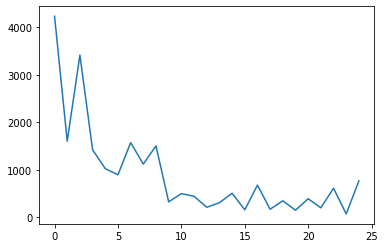

In [49]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = CNNLSTM(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [50]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 41.04% 
ROC/AUC: 0.68 
Precision: 0.92 
Recall: 0.35 
F1 score: 0.92


### RCNN

Epoch 1/25
16/16 - 2s - loss: 0.9357 - accuracy: 0.5449 - auc_39: 0.5451 - precision_39: 0.5357 - recall_39: 0.4339 - f1_score: 0.6514 - val_loss: 0.8692 - val_accuracy: 0.5139 - val_auc_39: 0.5265 - val_precision_39: 0.6250 - val_recall_39: 0.0403 - val_f1_score: 0.6613 - 2s/epoch - 110ms/step
Epoch 2/25
16/16 - 0s - loss: 0.7627 - accuracy: 0.5649 - auc_39: 0.5817 - precision_39: 0.6000 - recall_39: 0.2975 - f1_score: 0.6514 - val_loss: 0.7865 - val_accuracy: 0.5179 - val_auc_39: 0.5524 - val_precision_39: 0.8000 - val_recall_39: 0.0323 - val_f1_score: 0.6613 - 483ms/epoch - 30ms/step
Epoch 3/25
16/16 - 0s - loss: 0.7529 - accuracy: 0.5130 - auc_39: 0.5513 - precision_39: 0.4962 - recall_39: 0.5413 - f1_score: 0.6514 - val_loss: 0.7244 - val_accuracy: 0.4980 - val_auc_39: 0.5711 - val_precision_39: 0.4960 - val_recall_39: 0.9919 - val_f1_score: 0.6613 - 488ms/epoch - 30ms/step
Epoch 4/25
16/16 - 0s - loss: 0.7150 - accuracy: 0.5429 - auc_39: 0.5603 - precision_39: 0.5607 - recall_39:

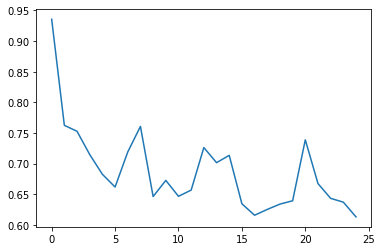

Epoch 1/25
16/16 - 2s - loss: 1.0036 - accuracy: 0.4870 - auc_40: 0.4843 - precision_40: 0.4578 - recall_40: 0.3128 - f1_score: 0.6532 - val_loss: 0.7703 - val_accuracy: 0.4940 - val_auc_40: 0.5942 - val_precision_40: 0.4920 - val_recall_40: 1.0000 - val_f1_score: 0.6578 - 2s/epoch - 110ms/step
Epoch 2/25
16/16 - 0s - loss: 0.7346 - accuracy: 0.5329 - auc_40: 0.5855 - precision_40: 0.5135 - recall_40: 0.7037 - f1_score: 0.6532 - val_loss: 0.7050 - val_accuracy: 0.5179 - val_auc_40: 0.5081 - val_precision_40: 0.7500 - val_recall_40: 0.0244 - val_f1_score: 0.6578 - 480ms/epoch - 30ms/step
Epoch 3/25
16/16 - 0s - loss: 0.7313 - accuracy: 0.5389 - auc_40: 0.5678 - precision_40: 0.5789 - recall_40: 0.1811 - f1_score: 0.6532 - val_loss: 0.7072 - val_accuracy: 0.5179 - val_auc_40: 0.5227 - val_precision_40: 0.7500 - val_recall_40: 0.0244 - val_f1_score: 0.6578 - 484ms/epoch - 30ms/step
Epoch 4/25
16/16 - 0s - loss: 0.6962 - accuracy: 0.5269 - auc_40: 0.5720 - precision_40: 0.5183 - recall_40:

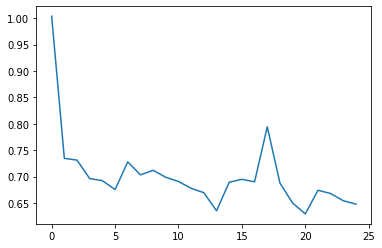

Epoch 1/25
16/16 - 2s - loss: 0.9505 - accuracy: 0.5179 - auc_41: 0.5635 - precision_41: 0.5076 - recall_41: 0.6802 - f1_score: 0.6595 - val_loss: 1.1209 - val_accuracy: 0.5520 - val_auc_41: 0.5917 - val_precision_41: 0.8889 - val_recall_41: 0.0672 - val_f1_score: 0.6450 - 2s/epoch - 109ms/step
Epoch 2/25
16/16 - 0s - loss: 0.8083 - accuracy: 0.5518 - auc_41: 0.5861 - precision_41: 0.5417 - recall_41: 0.5789 - f1_score: 0.6595 - val_loss: 1.0098 - val_accuracy: 0.4680 - val_auc_41: 0.6112 - val_precision_41: 0.4713 - val_recall_41: 0.9664 - val_f1_score: 0.6450 - 479ms/epoch - 30ms/step
Epoch 3/25
16/16 - 0s - loss: 0.7320 - accuracy: 0.5578 - auc_41: 0.6095 - precision_41: 0.5502 - recall_41: 0.5547 - f1_score: 0.6595 - val_loss: 0.7961 - val_accuracy: 0.5440 - val_auc_41: 0.6104 - val_precision_41: 0.7273 - val_recall_41: 0.0672 - val_f1_score: 0.6450 - 477ms/epoch - 30ms/step
Epoch 4/25
16/16 - 1s - loss: 0.7147 - accuracy: 0.5717 - auc_41: 0.5711 - precision_41: 0.6905 - recall_41:

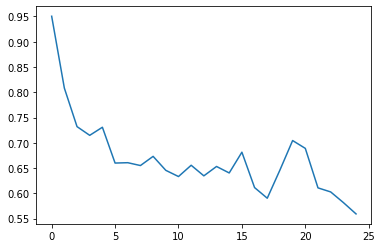

In [51]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = RCNN(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [52]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 84.70% 
ROC/AUC: 0.47 
Precision: 0.86 
Recall: 0.98 
F1 score: 0.93


## 4. Multimodal Late Fusion

### Dataset

In [53]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', binary=True, fusion=True)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(752, 1, 350, 35) (752, 1)
(268, 1, 350, 35) (268, 1)


In [54]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', binary=True)
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(752, 1, 350, 25) (752, 1)
(268, 1, 350, 25) (268, 1)


In [55]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### CNN + Bidirectional LSTM

In [56]:
class fusioned_CNNLSTM():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_1)
        flatten_1 = TimeDistributed(Flatten())(maxpool_1)
        lstm_1 = LSTM(64)(flatten_1)
        dense_1 = Dense(64, activation='relu')(lstm_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2)
        flatten_2 = TimeDistributed(Flatten())(maxpool_2)
        lstm_2 = LSTM(64)(flatten_2)
        dense_2 = Dense(64, activation='relu')(lstm_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='sigmoid')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
16/16 - 5s - loss: 0.7288 - accuracy: 0.4810 - auc_42: 0.5190 - precision_42: 0.4819 - recall_42: 0.9917 - f1_score: 0.6514 - val_loss: 0.7129 - val_accuracy: 0.4940 - val_auc_42: 0.4961 - val_precision_42: 0.4940 - val_recall_42: 0.9919 - val_f1_score: 0.6613 - 5s/epoch - 303ms/step
Epoch 2/25
16/16 - 1s - loss: 0.7111 - accuracy: 0.4850 - auc_42: 0.5080 - precision_42: 0.4840 - recall_42: 1.0000 - f1_score: 0.6514 - val_loss: 0.7032 - val_accuracy: 0.4980 - val_auc_42: 0.4923 - val_precision_42: 0.4960 - val_recall_42: 0.9919 - val_f1_score: 0.6613 - 767ms/epoch - 48ms/step
Epoch 3/25
16/16 - 1s - loss: 0.7014 - accuracy: 0.4870 - auc_42: 0.5206 - precision_42: 0.4850 - recall_42: 1.0000 - f1_score: 0.6514 - val_loss: 0.6972 - val_accuracy: 0.4980 - val_auc_42: 0.4923 - val_precision_42: 0.4960 - val_recall_42: 0.9919 - val_f1_score: 0.6613 - 764ms/epoch - 48ms/step
Epoch 4/25
16/16 - 1s - loss: 0.6972 - accuracy: 0.4870 - auc_42: 0.4639 - precision_42: 0.4850 - recall_42:

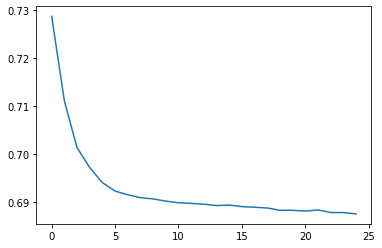

Epoch 1/25
16/16 - 4s - loss: 0.6945 - accuracy: 0.5210 - auc_43: 0.5176 - precision_43: 0.7143 - recall_43: 0.0206 - f1_score: 0.6532 - val_loss: 0.6932 - val_accuracy: 0.4980 - val_auc_43: 0.4876 - val_precision_43: 0.2000 - val_recall_43: 0.0081 - val_f1_score: 0.6578 - 4s/epoch - 267ms/step
Epoch 2/25
16/16 - 1s - loss: 0.6946 - accuracy: 0.5110 - auc_43: 0.4801 - precision_43: 0.4667 - recall_43: 0.0576 - f1_score: 0.6532 - val_loss: 0.6920 - val_accuracy: 0.5100 - val_auc_43: 0.5945 - val_precision_43: 0.0000e+00 - val_recall_43: 0.0000e+00 - val_f1_score: 0.6578 - 791ms/epoch - 49ms/step
Epoch 3/25
16/16 - 1s - loss: 0.6935 - accuracy: 0.5170 - auc_43: 0.4632 - precision_43: 1.0000 - recall_43: 0.0041 - f1_score: 0.6532 - val_loss: 0.6939 - val_accuracy: 0.5100 - val_auc_43: 0.4880 - val_precision_43: 0.5000 - val_recall_43: 0.0081 - val_f1_score: 0.6578 - 784ms/epoch - 49ms/step
Epoch 4/25
16/16 - 1s - loss: 0.6931 - accuracy: 0.5190 - auc_43: 0.4865 - precision_43: 1.0000 - re

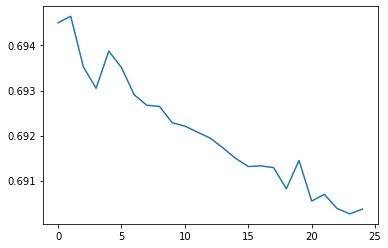

Epoch 1/25
16/16 - 4s - loss: 0.6976 - accuracy: 0.4841 - auc_44: 0.4714 - precision_44: 0.4748 - recall_44: 0.4575 - f1_score: 0.6595 - val_loss: 0.6917 - val_accuracy: 0.4840 - val_auc_44: 0.5320 - val_precision_44: 0.4798 - val_recall_44: 1.0000 - val_f1_score: 0.6450 - 4s/epoch - 267ms/step
Epoch 2/25
16/16 - 1s - loss: 0.6942 - accuracy: 0.4940 - auc_44: 0.5061 - precision_44: 0.4929 - recall_44: 0.9879 - f1_score: 0.6595 - val_loss: 0.6900 - val_accuracy: 0.4840 - val_auc_44: 0.5238 - val_precision_44: 0.4797 - val_recall_44: 0.9916 - val_f1_score: 0.6450 - 776ms/epoch - 49ms/step
Epoch 3/25
16/16 - 1s - loss: 0.6936 - accuracy: 0.4562 - auc_44: 0.5017 - precision_44: 0.4545 - recall_44: 0.5263 - f1_score: 0.6595 - val_loss: 0.6895 - val_accuracy: 0.5400 - val_auc_44: 0.5238 - val_precision_44: 1.0000 - val_recall_44: 0.0336 - val_f1_score: 0.6450 - 792ms/epoch - 49ms/step
Epoch 4/25
16/16 - 1s - loss: 0.6936 - accuracy: 0.5040 - auc_44: 0.4792 - precision_44: 0.2500 - recall_44:

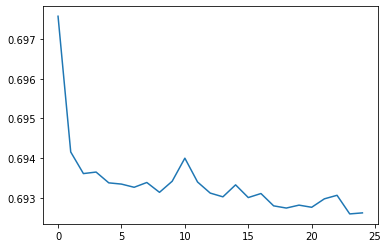

In [57]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_CNNLSTM(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [58]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 14.93% 
ROC/AUC: 0.53 
Precision: 1.00 
Recall: 0.01 
F1 score: 0.93


### RCNN

In [59]:
class fusioned_RCNN():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_1)
        bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
        flatten_1 = Flatten()(maxpool_1)
        dense_1 = Dense(64)(flatten_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_2)
        bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
        flatten_2 = Flatten()(maxpool_2)
        dense_2 = Dense(64)(flatten_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='sigmoid')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
16/16 - 3s - loss: 1.4129 - accuracy: 0.5549 - auc_45: 0.5775 - precision_45: 0.5422 - recall_45: 0.5041 - f1_score: 0.6514 - val_loss: 34.7990 - val_accuracy: 0.4940 - val_auc_45: 0.5000 - val_precision_45: 0.4940 - val_recall_45: 1.0000 - val_f1_score: 0.6613 - 3s/epoch - 183ms/step
Epoch 2/25
16/16 - 1s - loss: 1.2627 - accuracy: 0.6387 - auc_45: 0.6940 - precision_45: 0.6225 - recall_45: 0.6405 - f1_score: 0.6523 - val_loss: 6.2931 - val_accuracy: 0.4900 - val_auc_45: 0.5165 - val_precision_45: 0.4919 - val_recall_45: 0.9758 - val_f1_score: 0.6613 - 722ms/epoch - 45ms/step
Epoch 3/25
16/16 - 1s - loss: 1.0622 - accuracy: 0.6287 - auc_45: 0.6809 - precision_45: 0.6207 - recall_45: 0.5950 - f1_score: 0.6514 - val_loss: 2.3095 - val_accuracy: 0.5418 - val_auc_45: 0.6231 - val_precision_45: 0.5205 - val_recall_45: 0.9194 - val_f1_score: 0.6613 - 702ms/epoch - 44ms/step
Epoch 4/25
16/16 - 1s - loss: 1.0106 - accuracy: 0.6128 - auc_45: 0.6645 - precision_45: 0.5952 - recall_45

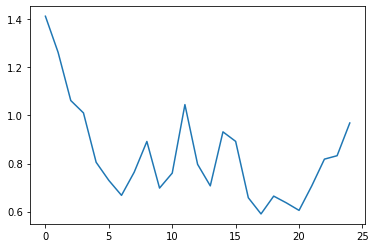

Epoch 1/25
16/16 - 2s - loss: 1.1159 - accuracy: 0.6188 - auc_46: 0.6374 - precision_46: 0.6083 - recall_46: 0.6008 - f1_score: 0.6532 - val_loss: 18.3838 - val_accuracy: 0.4900 - val_auc_46: 0.5000 - val_precision_46: 0.4900 - val_recall_46: 1.0000 - val_f1_score: 0.6578 - 2s/epoch - 141ms/step
Epoch 2/25
16/16 - 1s - loss: 1.0550 - accuracy: 0.6128 - auc_46: 0.6479 - precision_46: 0.6000 - recall_46: 0.6049 - f1_score: 0.6532 - val_loss: 6.7932 - val_accuracy: 0.4940 - val_auc_46: 0.5234 - val_precision_46: 0.4920 - val_recall_46: 1.0000 - val_f1_score: 0.6578 - 725ms/epoch - 45ms/step
Epoch 3/25
16/16 - 1s - loss: 0.8446 - accuracy: 0.6627 - auc_46: 0.7256 - precision_46: 0.6468 - recall_46: 0.6708 - f1_score: 0.6532 - val_loss: 2.6744 - val_accuracy: 0.5020 - val_auc_46: 0.6462 - val_precision_46: 0.4960 - val_recall_46: 1.0000 - val_f1_score: 0.6578 - 733ms/epoch - 46ms/step
Epoch 4/25
16/16 - 1s - loss: 0.8913 - accuracy: 0.6427 - auc_46: 0.6924 - precision_46: 0.6481 - recall_46

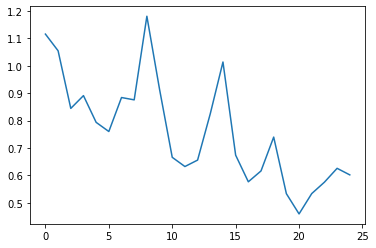

Epoch 1/25
16/16 - 2s - loss: 1.2316 - accuracy: 0.5717 - auc_47: 0.6064 - precision_47: 0.5602 - recall_47: 0.6032 - f1_score: 0.6595 - val_loss: 12.8703 - val_accuracy: 0.5360 - val_auc_47: 0.5130 - val_precision_47: 0.8000 - val_recall_47: 0.0336 - val_f1_score: 0.4800 - 2s/epoch - 141ms/step
Epoch 2/25
16/16 - 1s - loss: 0.8488 - accuracy: 0.6454 - auc_47: 0.7022 - precision_47: 0.6432 - recall_47: 0.6275 - f1_score: 0.6595 - val_loss: 4.4686 - val_accuracy: 0.5480 - val_auc_47: 0.5404 - val_precision_47: 0.8000 - val_recall_47: 0.0672 - val_f1_score: 0.6450 - 711ms/epoch - 44ms/step
Epoch 3/25
16/16 - 1s - loss: 0.8624 - accuracy: 0.6315 - auc_47: 0.6771 - precision_47: 0.6292 - recall_47: 0.6113 - f1_score: 0.6595 - val_loss: 10.4217 - val_accuracy: 0.4760 - val_auc_47: 0.5000 - val_precision_47: 0.4760 - val_recall_47: 1.0000 - val_f1_score: 0.6450 - 730ms/epoch - 46ms/step
Epoch 4/25
16/16 - 1s - loss: 0.9852 - accuracy: 0.6454 - auc_47: 0.7076 - precision_47: 0.6332 - recall_4

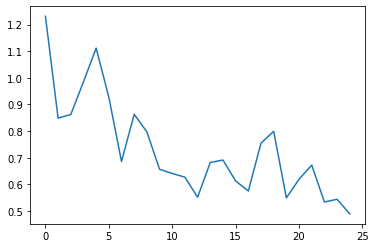

In [60]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_RCNN(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [61]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 56.72% 
ROC/AUC: 0.52 
Precision: 0.87 
Recall: 0.59 
F1 score: 0.93


### Ensemble

In [62]:
class KerasMember():
    def __init__(self, name=None, keras_model=None, train_batches=None,
                 val_batches=None, submission_probs=None, keras_modelpath=None,
                 keras_kwargs={}):
        assert(name is not None)
        self.name = name
        self.model = keras_model
        self.submission_probs = submission_probs
        # Initialize Params
        self.val_probs = None
        self.train_probs = None
        self.val_classes = None
        self.train_classes = None
        if (keras_model is None) and (keras_modelpath is not None):
            self.load_kerasmodel(self.keras_modelpath, self.keras_kwargs)
        if train_batches is not None:
            self._calculate_train_predictions(train_batches)
        if val_batches is not None:
            self._calculate_val_predictions(val_batches)

    def _test_datatuple(self, datatuple):
        assert(len(datatuple) == 2)
        assert(datatuple[0].shape[0] == datatuple[1].shape[0])

    def _calculate_predictions(self, batches):
        if hasattr(batches, 'shuffle'):
            batches.reset()
            batches.shuffle = False
        if type(batches) is tuple:
            self._test_datatuple(batches)
            return self.model.predict(batches[0])
        return self.model.predict_generator(
            batches, steps=(batches.n // batches.batch_size) + 1, verbose=1)

    def _calculate_val_predictions(self, val_batches):
        if type(val_batches) is tuple:
            self.val_classes = val_batches[1]
        elif hasattr(val_batches, 'classes'):
            self.val_classes = np.array(val_batches.classes)
        elif hasattr(val_batches, 'y'):
            self.val_classes = np.array(val_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.val_probs = self._calculate_predictions(val_batches)
        return self.val_probs

    def _calculate_train_predictions(self, train_batches):
        if type(train_batches) is tuple:
            self.train_classes = train_batches[1]
        elif hasattr(train_batches, 'classes'):
            self.train_classes = np.array(train_batches.classes)
        elif hasattr(train_batches, 'y'):
            self.train_classes = np.array(train_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.train_probs = self._calculate_predictions(train_batches)
        return self.train_probs


def _calculate_metric(y_true, y_pred, metric=None):
    if metric is None:
        metric = roc_auc_score
    y_t = y_true
    y_p = y_pred
    if metric == roc_auc_score:
        return metric(y_t, y_p, multi_class='ovo')
    if y_true.ndim > 1:
        y_t = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:
        y_p = np.argmax(y_pred, axis=1)
    if metric is precision_recall_fscore_support:
        return precision_recall_fscore_support(y_t, y_p, average='macro')
    return metric(y_t, y_p)

class DirichletEnsemble():
    def __init__(self, N=10000, metric=None, maximize=True):
        self.n = N
        self.metric = metric
        if metric is None:
            self.metric = roc_auc_score
        self.maximize = maximize
        # Initialize Parameters:
        self.members = []
        self.bestweights = []
        self.probabilities = None
        self._nmembers = 0
        self.bestscore = float("-inf") if maximize else float("inf")
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.fitted = False

    def add_members(self, members):
        for member in members:
            self.add_member(member)

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1

    def fit(self, verbose=False):
        assert(len(self.members) > 1)
        val_classes = self.members[0].val_classes
        best_ensemble_score = float("-inf") if self.maximize else float("inf")
        best_ensemble_accuracy = 0
        best_ensemble_p = 0
        best_ensemble_r = 0
        best_ensemble_f1 = 0
        rsbest = None
        for i in range(self.n):
            rs = np.random.dirichlet(np.ones(self._nmembers), size=1)[0]
            preds = np.sum(np.array([self.members[i].val_probs * rs[i]
                                     for i in range(self._nmembers)]), axis=0)
            ensemble_score = _calculate_metric(val_classes, preds)
            ensemble_accuracy = _calculate_metric(val_classes, preds, accuracy_score)
            ensemble_prf1 = _calculate_metric(val_classes, preds, precision_recall_fscore_support)
            ensemble_p = ensemble_prf1[0]
            ensemble_r = ensemble_prf1[1]
            ensemble_f1 = ensemble_prf1[2]
            max_flag = self.maximize and ensemble_score > best_ensemble_score
            min_flag = not(
                self.maximize) and ensemble_score < best_ensemble_score
            if max_flag or min_flag:
                if verbose:
                    print(ensemble_score, i, rs) 
                best_ensemble_score = ensemble_score
                rsbest = rs
            if ensemble_accuracy > best_ensemble_accuracy:
                if verbose:
                    print(ensemble_accuracy, i, rs) 
                best_ensemble_accuracy = ensemble_accuracy
            if ensemble_p > best_ensemble_p:
                if verbose:
                    print(ensemble_p, i, rs) 
                best_ensemble_p = ensemble_p
            if ensemble_r > best_ensemble_r:
                if verbose:
                    print(ensemble_r, i, rs) 
                best_ensemble_r = ensemble_r
            if ensemble_f1 > best_ensemble_f1:
                if verbose:
                    print(ensemble_f1, i, rs) 
                best_ensemble_f1 = ensemble_f1
        self.bestweights = rsbest
        self.bestscore = best_ensemble_score
        self.accuracy = best_ensemble_accuracy
        self.precision = best_ensemble_p
        self.recall = best_ensemble_r
        self.f1 = best_ensemble_f1

    def predict(self):
        self.probabilities = np.sum(np.array([self.bestweights[i] *
                                              self.members[i].submission_probs
                                              for i in range(self._nmembers)]),
                                    axis=0)
        return self.probabilities
        
    def describe(self):
        for i in range(self._nmembers):
            member = self.members[i]
            text = member.name + " (weight: {:1.4f})".format(self.bestweights[i])
            print(text)
        print("Accuracy: {:1.2f}% - ROC/AUC: {:1.2f} - Precision: {:1.2f} - Recall: {:1.2f} - F1 score: {:1.2f}".format(
            self.accuracy * 100, self.bestscore, self.precision, self.recall, self.f1))
        return self.bestscore

In [63]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_binary_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_binary_body_model, train_batches=(body_X_train, body_y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_binary_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_binary_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))

In [64]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [65]:
e = dirichletEnsemble.describe()
cnn_auc.append(round(e, 2))
rnn_auc.append(0)

CNN + Bidirectional LSTM Body Model (weight: 0.1110)
RCNN Body Model (weight: 0.1936)
CNN + Bidirectional LSTM Face Model (weight: 0.1572)
RCNN Face Model (weight: 0.5382)
Accuracy: 100.00% - ROC/AUC: 0.67 - Precision: 1.00 - Recall: 1.00 - F1 score: 1.00


## Results

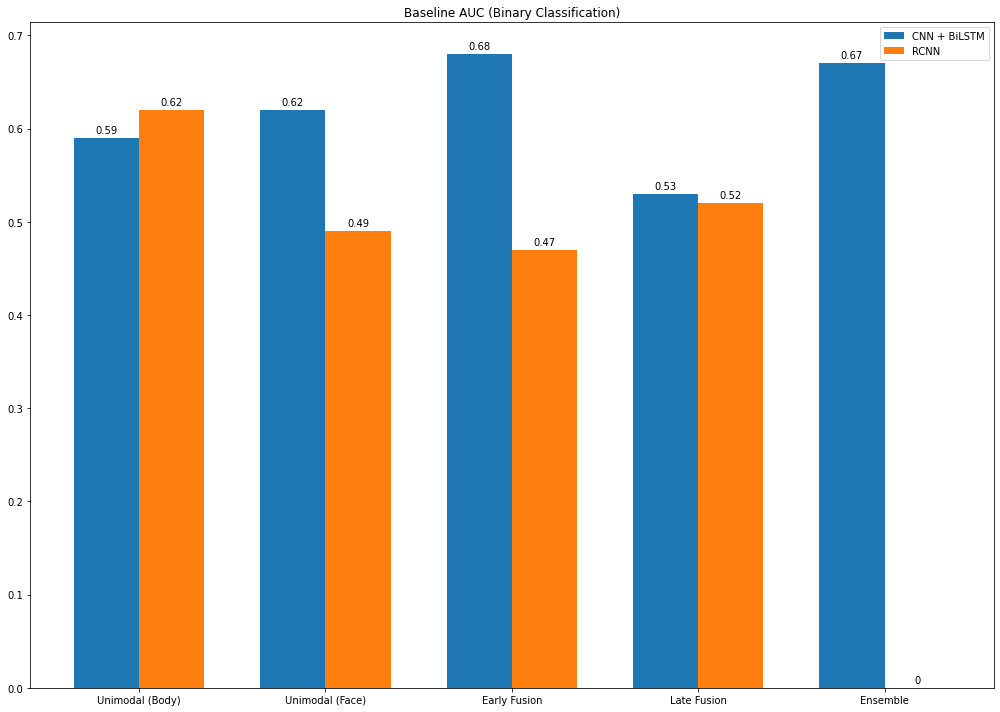

In [66]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion', 'Ensemble']
men_means = cnn_auc
women_means = rnn_auc

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, men_means, width, label='CNN + BiLSTM')
rects2 = ax.bar(x + width/2, women_means, width, label='RCNN')

ax.set_title('Baseline AUC (Binary Classification)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()